In [201]:
import importlib
import  vit_.cifar_dataloader as cifar_dataloader
importlib.reload(cifar_dataloader)
import  vit_.cifar_dataloader as cifar_dataloader
from vit_.cifar_dataloader import dataloader2

import train_evaluate
importlib.reload(train_evaluate)
import train_evaluate
from train_evaluate import train,validate,evaluate


import torchvision.models as models
import numpy  as np
import numpy as np
import seaborn as sns
import torch
import torchvision.models as models
import torch.nn as nn




sns.set()

## vit model

In [188]:
class CreatePatches(nn.Module):
    def __init__(
        self, channels=3, embed_dim=768, patch_size=16
    ):
        super().__init__()
        self.patch = nn.Conv2d(
            in_channels=channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
    def forward(self, x):
        # Flatten along dim = 2 to maintain channel dimension.
        patches = self.patch(x).flatten(2).transpose(1, 2)
        return patches

In [164]:
from PIL import Image
from torchvision import transforms
# 读取图像

image = Image.open('/Users/jiawen/Desktop/test.jpg')
image = image.convert('RGB')
# 显示图像（可选）
image.show()


In [165]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),  # 将图像转换为张量
])

# 应用转换
tensor_image = transform(image)

# 查看张量的形状
print(tensor_image.shape)

torch.Size([3, 224, 224])


In [185]:
patches=CreatePatches()
patches_=patches(tensor_image)
print(patches_.shape)
patches_=patches_.permute(1,2,0)
patches_=patches_.view(14,14,16,16,3)

torch.Size([768, 14, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


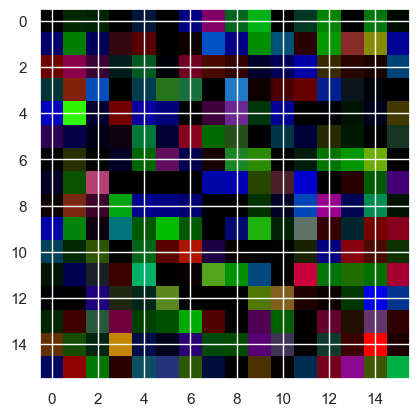

In [183]:
import matplotlib.pyplot as plt
a=patches_[0,0,:]
a=a.detach().numpy()
plt.imshow(a)

In [189]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.pre_norm = nn.LayerNorm(embed_dim, eps=1e-06)
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-06)
        self.MLP = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x_norm = self.pre_norm(x)
        # MultiheadAttention returns attention output and weights,
        # we need only the outputs, so [0] index.
        x = x + self.attention(x_norm, x_norm, x_norm)[0]
        x = x + self.MLP(self.norm(x))
        return x

In [202]:
class ViT(nn.Module):
    def __init__(
        self, 
        img_size=224,
        in_channels=3,
        patch_size=16,
        embed_dim=768,
        hidden_dim=3072,
        num_heads=12,
        num_layers=12,
        dropout=0.0,
        num_classes=3
    ):
        super().__init__()
        self.patch_size = patch_size
        num_patches = (img_size//patch_size) ** 2
        self.patches = CreatePatches(
            channels=in_channels,
            embed_dim=embed_dim,
            patch_size=patch_size
        )
        # Postional encoding.
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.attn_layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.attn_layers.append(
                AttentionBlock(embed_dim, hidden_dim, num_heads, dropout)
            )
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(embed_dim, eps=1e-06)
        self.head = nn.Linear(embed_dim, num_classes)
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    def forward(self, x):
        x = self.patches(x)
        b, n, _ = x.shape
 
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        for layer in self.attn_layers:
            x = layer(x)
        x = self.ln(x)
        x = x[:, 0]
        return self.head(x)

In [203]:
vit_full=ViT(img_size=224,
        in_channels=3,
        patch_size=16,
        embed_dim=768,
        hidden_dim=3072,
        num_heads=12,
        num_layers=12,
        dropout=0.0,
        num_classes=3)

## pretrain model

In [204]:
CIFAR = np.load('./datasets/CIFAR.npz')
train_loader,val_loader,test_loader=dataloader2(CIFAR)

(160, 32, 32, 3)


In [12]:
weights = models.ViT_B_16_Weights.DEFAULT
vit = models.vit_b_16(weights=weights)

In [13]:
class VIT(nn.Module):
    def __init__(self, output_shape):
        super(VIT, self).__init__()

        self.pretrained = models.vit_b_16(weights=weights)
        for param in self.pretrained.parameters():
            param.requires_grad = False

        pretrained_output = 1000
        self.fc = torch.nn.Sequential(
            nn.Linear(in_features=pretrained_output,
                      out_features=output_shape,
                      bias=False),
        )

    def forward(self, image):
        output = self.pretrained(image)
        output = self.fc(output)
        return output

vit = VIT(output_shape=3)

In [206]:
def run(dataset,epochs=10,lr=0.01):

    train_loader,val_loader,test_loader=dataloader2(dataset)
    #model=resnet18
    #model=Lenet()
    ## review
    model=vit_full

    # resnet18 = resnet18.fc.in_features
    # resnet18.fc = nn.Linear(num_ftrs, 3)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        train_acc, train_loss=train(model,criterion, optimizer, train_loader)
        val_acc, val_loss=validate(model,criterion, val_loader)
        test_acc, test_loss=validate(model,criterion, test_loader)

        training_accuracies.append(train_acc)
        training_losses.append(train_loss)
        validation_accuracies.append(val_acc)
        validation_losses.append(val_loss)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)


        print(f"epoch: {epoch}\n \
            train_acc: {train_acc}, train_loss: {train_loss}\n \
            val_acc: {val_acc}, val_loss: {val_loss}\n \
            test_acc: {test_acc}, test_loss: {test_loss}\n")
    #precision,recall,accuracy=evaluate(dataset,model)


    return (training_accuracies,training_losses,
            validation_accuracies,
            validation_losses,
            test_accuracies,
            test_losses,
            # precision,
            # recall,
            # accuracy,
            model)

In [207]:
(training_accuracies,training_losses,
validation_accuracies,
validation_losses,
test_accuracies,
test_losses,
precision,
recall,
accuracy,
model)=run(CIFAR,epochs=3,lr=0.01)

(160, 32, 32, 3)
train_shape torch.Size([64, 3])
train_shape torch.Size([64, 3])
train_shape torch.Size([32, 3])
epoch: 0
             train_acc: 0.31875, train_loss: 3.747627305984497
             val_acc: 0.4, val_loss: 2.120547294616699
             test_acc: 0.3333333333333333, test_loss: 2.5403476479848224



ValueError: not enough values to unpack (expected 10, got 7)